##To do
1. predict_log_proba
2. Markdown
3. 排序給予權重，再去計算準確度？ 純看標籤會不會不準？
4. 取前八筆，給予最近的兩(N)筆不同權重(不同的Column來呈現，不要全部放一起)
5. 每一筆自己的Raw rank?
6. 選擇Algorithm (目前留下logreg / KNN / RFC / Bagging)


# 目的

此 Notebook 的目的在於透過顧客的交易紀錄，進而預測此顧客未來的顧客屬性。

我們將顧客屬性分為 ABCDEF 六個等級，未來有新的一筆交易資料進來時，可以透過其歷史購買紀錄和購買種類分布，透過機器學習方式預測其未來最終可能對公司的總貢獻是屬於哪個顧客屬性。

目前擁有的Dataset作為歷史訓練資料集，可以得到他的歷史Rank (god) 以及前N筆購買紀錄當下的Rank變動。

當未來有一筆新的交易紀錄近來，我可以透過此顧客的歷史交易紀錄，來預測此消費者的顧客屬性，並作為後續Promotion / Ecoupon的投遞依據。

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import gc
# %matplotlib inline

In [3]:
import scipy
import seaborn

In [4]:
order = pd.read_csv("Orders.csv")

order.drop(index = order[order['StatusDef'] != 'Finish'].index, axis=0, inplace=True)
order.drop(index = order[order['IsGift'] == True].index, axis=0, inplace=True)

order['Mean_Payment'] = order['SalesOrderSlaveTotalPayment'] / order['Quantity']

## 資料處理

首先先處理所有歷史資料，並且給予 god 的標籤，作為預測的目標

首先我們將資料形式做轉變，確保每一個Row僅代表一個商品


In [5]:
order_new = order.drop(columns=order.columns[3:11])
order_new = order_new.drop(columns=order.columns[13:16])
order_new = order_new.drop(columns=order.columns[17:])

repeats = []
for i in range(order_new.shape[0]):
    repeats.append(order_new['Quantity'].values[i])
repeats = np.array(repeats)

order_new = pd.DataFrame(np.repeat(order_new.values, repeats, axis=0), columns=order_new.columns)
order_new['Quantity'] = 1

接著我們將商品種類分群，做為未來商品類別分類的依據

In [6]:
# order_new['UnitPrice'].quantile(.99) == 640  // max == 3500
unit_price_group = pd.cut(order_new['UnitPrice'], bins=[0,160,320,480,640,800,3500]).to_frame()
unit_price_group.columns = ['UnitPriceGroup']
unit_price_group['MemberId'] = order['MemberId']
order_new['UnitPriceGroup'] = unit_price_group['UnitPriceGroup']

In [7]:
order_new = pd.get_dummies(order_new, columns=['UnitPriceGroup'])
order_new.head()

,DateId,MemberId,OrderGroupCode,Quantity,UnitPrice,SalesOrderSlaveTotalPayment,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 3500]"
0,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,350,350,0,0,1,0,0,0
1,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,199,199,0,1,0,0,0,0
2,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,199,199,0,1,0,0,0,0
3,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,225,225,0,1,0,0,0,0
4,20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",1,100,100,1,0,0,0,0,0


In [8]:
order_df = order_new.groupby(['MemberId'])[['Quantity','UnitPriceGroup_(0, 160]', 'UnitPriceGroup_(160, 320]',
       'UnitPriceGroup_(320, 480]', 'UnitPriceGroup_(480, 640]',
       'UnitPriceGroup_(640, 800]', 'UnitPriceGroup_(800, 3500]']].sum().reset_index()

為了瞭解此顧客的購買次數，我們產生一個新的Dataset叫 Order_count，記錄此MemberId的交易筆數

In [9]:
order_count = order_new.groupby(['MemberId','OrderGroupCode']).count().reset_index()[['MemberId','DateId']]
order_count = order_count.groupby(['MemberId']).count().reset_index()

In [10]:
order_count.columns = ['MemberId','Count']
order_df['Count'] = order_count['Count']

接著我們整理資料，準備生成歷史Rank (god)

In [11]:
order_info = order.drop_duplicates(subset=['MemberId'], keep='first')
order_info.drop(columns=['DateId','OrderGroupCode','Quantity','SalesOrderSlaveId','SalePageId','IsMajor','IsGift','UnitPrice',
                        'PromotionDiscount','ECouponDiscount','SalesOrderSlaveTotalPayment', 'SalesOrderSlaveDateTime',
                       'SalesOrderReceiverId','ZipCode', 'StoreName','StoreId', 'StatusDef', 'ReturnGoodsDateId',
                       'CauseDef','District','IsSalePageGift'], inplace=True)

order_info['MemberId'] = order_info['MemberId'].astype(str).astype(int)
order_df = pd.merge(order_info,order_df,how='left',on=['MemberId'])
order_df.drop(columns=['Mean_Payment'], inplace=True)

In [12]:
p_group = order[['MemberId','Mean_Payment']].groupby('MemberId').mean().reset_index()
order_df = pd.merge(order_df, p_group, on = ['MemberId'], how = 'left')
order_df.head()

,MemberId,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,ECouponId,City,DeliverTypeDef,Quantity,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 3500]",Count,Mean_Payment
0,1388133,Web,Mobile,SevenEleven,0,嘉義縣,SevenEleven,4,0.0,3.0,1.0,0.0,0.0,0.0,1,243.250000
1,365787,Web,Mobile,SevenEleven,0,桃園市,SevenEleven,10,6.0,4.0,0.0,0.0,0.0,0.0,2,148.300000
2,1388127,Web,Mobile,Family,0,台南市,Family,8,1.0,7.0,0.0,0.0,0.0,0.0,2,180.625000
3,1230537,AndroidApp,Mobile,CreditCardOnce,3916,新竹市,Home,57,0.0,35.0,16.0,6.0,0.0,0.0,5,306.245614
4,1388164,Web,PC,Family,0,新北市,Family,6,0.0,5.0,1.0,0.0,0.0,0.0,2,235.833333


取得總交易次數與平均購買金額的分布，進一步產生 bins 進行顧客屬性分類

In [13]:
p_ranking = order.groupby(['MemberId'])[['Mean_Payment']].mean().reset_index()
q_ranking = order.groupby(['MemberId'])[['Quantity']].sum().reset_index()

p_bins = [0, p_ranking['Mean_Payment'].quantile(0.25), p_ranking['Mean_Payment'].quantile(0.5), p_ranking['Mean_Payment'].quantile(0.75), p_ranking['Mean_Payment'].max()]
q_bins = [0, q_ranking['Quantity'].quantile(0.25), q_ranking['Quantity'].quantile(0.5), q_ranking['Quantity'].quantile(0.75), q_ranking['Quantity'].max()]

得到分布後直接進行分類，並且整理與重新排序Dataset

In [14]:
order_df = order_df.assign(A = np.where((order_df['Mean_Payment'] > p_bins[3]) & (order_df['Quantity'] > q_bins[3]), 1,0))
order_df = order_df.assign(B = np.where((order_df['Mean_Payment'] > p_bins[2]) & (order_df['Quantity'] > q_bins[2]) & ((order_df['Quantity'] <= q_bins[3]) | (order_df['Mean_Payment'] <= p_bins[3])), 1,0))
order_df = order_df.assign(C = np.where((order_df['Mean_Payment'] > p_bins[2]) & (order_df['Quantity'] <= q_bins[2]), 1,0))
order_df = order_df.assign(D = np.where((order_df['Mean_Payment'] <= p_bins[2]) & (order_df['Quantity'] > q_bins[2]), 1,0))
order_df = order_df.assign(E = np.where((order_df['Mean_Payment'] <= p_bins[2]) & (order_df['Quantity'] <= q_bins[2]) & ((order_df['Quantity'] > q_bins[1]) |(order_df['Mean_Payment'] > p_bins[1]) ), 1,0))
order_df = order_df.assign(F = np.where((order_df['Mean_Payment'] <= p_bins[1]) & (order_df['Quantity'] <= q_bins[1]), 1,0))

order_df.drop(columns=['Mean_Payment','Quantity'], inplace= True)

自己我們得到一個歷史資料的Rank (god)

In [15]:
order_df.head()

,MemberId,TrackSourceTypeDef,TrackDeviceTypeDef,PayProfileTypeDef,ECouponId,City,DeliverTypeDef,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 3500]",Count,A,B,C,D,E,F
0,1388133,Web,Mobile,SevenEleven,0,嘉義縣,SevenEleven,0.0,3.0,1.0,0.0,0.0,0.0,1,0,0,1,0,0,0
1,365787,Web,Mobile,SevenEleven,0,桃園市,SevenEleven,6.0,4.0,0.0,0.0,0.0,0.0,2,0,0,0,1,0,0
2,1388127,Web,Mobile,Family,0,台南市,Family,1.0,7.0,0.0,0.0,0.0,0.0,2,0,0,0,1,0,0
3,1230537,AndroidApp,Mobile,CreditCardOnce,3916,新竹市,Home,0.0,35.0,16.0,6.0,0.0,0.0,5,1,0,0,0,0,0
4,1388164,Web,PC,Family,0,新北市,Family,0.0,5.0,1.0,0.0,0.0,0.0,2,0,1,0,0,0,0


In [16]:
rank = pd.Series(order_df['A B C D E F'.split(' ')].columns[np.where(order_df['A B C D E F'.split(' ')]!=0)[1]])
order_df['Rank'] = rank

god = order_df[['MemberId','Count','Rank']]
god.columns = ['MemberId','Count','God']
god.head(10)

,MemberId,Count,God
0,1388133,1,C
1,365787,2,D
2,1388127,2,D
3,1230537,5,A
4,1388164,2,B
5,1388138,1,E
6,1370967,6,D
7,1388120,1,D
8,505220,2,E
9,1388211,1,F


In [17]:
del order_info, order_new, order_df, p_group
del p_ranking, q_ranking, p_bins, q_bins, unit_price_group
del rank, repeats

import gc
gc.collect()

140

我們已經取得歷史資料的Rank，作為後續機學習的預測目標。接下來我們必須整理資料，找出頭N筆的交易紀錄，並且根據這個紀錄給予當下的Rank。

倘若我們能知道前T筆的交易紀錄即可預測出他未來的顧客屬性，那我們就可以及時給予適當的Promotion 和 Ecoupon 讓客戶購買更多商品 / 購買更多次數

------------------------------------------------------------

下方我們依序整理出頭一筆 至 頭十筆的交易紀錄，以及當下的Rank

In [18]:
# 取出每個MemberId第一筆購買紀錄
member_1st_purchase_date = order.sort_values(by='DateId').groupby('MemberId')[['DateId','OrderGroupCode']].nth(0).reset_index() 

# Join兩個Dataset，留下第一筆購買紀錄
merge_1st = pd.merge(order, member_1st_purchase_date, on = ['MemberId','DateId','OrderGroupCode'], how = 'right')
# merge_1st = merge.copy()

In [19]:
def clean_data(dataset):
    
    p_group = dataset[['MemberId','Mean_Payment']].groupby('MemberId').mean().reset_index()
    s_group = dataset[['MemberId','SalesOrderSlaveTotalPayment']].groupby('MemberId').sum().reset_index()
    
    # Take out the last nth
    last_trans_date = dataset.groupby("MemberId")[['DateId']].nth(-1).reset_index()
    mer = pd.merge(dataset, last_trans_date, how='right', on=['MemberId','DateId'])
    temp = mer[['MemberId','DateId','UnitPrice']]
    del mer, last_trans_date
    gc.collect()
    upbound = order['UnitPrice'].quantile(.99)
    maxi = order['UnitPrice'].max()
    for i in [dataset, temp]:
        unit_price_group = pd.cut(i['UnitPrice'], bins=[0,upbound/4,upbound/2,3*upbound/4,upbound,maxi]).to_frame() # max = 2600
        unit_price_group.columns = ['UnitPriceGroup']
        unit_price_group['MemberId'] = i['MemberId']
        i['UnitPriceGroup'] = unit_price_group['UnitPriceGroup']
    del unit_price_group
    gc.collect()
    
    df_cut = dataset.drop_duplicates(subset = ['MemberId'], keep = 'first').reset_index()
    df_cut.drop(columns = ['DateId','index','SalesOrderSlaveId','Quantity', 'UnitPrice','PromotionDiscount','ECouponDiscount'], inplace=True)

    repeats = []
    for i in range(dataset.shape[0]):
        repeats.append(dataset['Quantity'].values[i])
    repeats = np.array(repeats)

    dataset = pd.DataFrame(np.repeat(dataset.values, repeats, axis=0), columns=dataset.columns)
    dataset = pd.get_dummies(dataset, columns = ['UnitPriceGroup'])
    dataset['Quantity'] = 1
    
    temp = pd.get_dummies(temp, columns= ['UnitPriceGroup'])
    temp.drop(columns=['UnitPrice','DateId'], inplace=True)
    dataset = pd.merge(dataset, temp, how='left', on=['MemberId'])

    del temp
    gc.collect()
    
    df_cut_group = dataset.groupby('MemberId').sum().reset_index()
    df_cut_group['MemberId'] = df_cut_group['MemberId'].astype(int)
    df_cut['MemberId'] = df_cut['MemberId'].astype(int)
    df_cut = pd.merge(df_cut, df_cut_group, on = 'MemberId', how = 'left')
    
    df_cut.drop(columns=['IsGift','IsMajor','StatusDef','OrderGroupCode','IsSalePageGift','ZipCode','StoreName','StoreId','ReturnGoodsDateId','CauseDef','District','SalesOrderSlaveDateTime','SalesOrderReceiverId','SalePageId'], axis=1, inplace=True)    

    del df_cut_group
    gc.collect()

    # ECoupon
    df_cut['ECoupon'] = (df_cut['ECouponId'] != 0)
    df_cut = df_cut.assign(ECoupon = np.where(df_cut['ECouponId'] !=0 , 1, 0))

    # City Area
    north = ['新北市','台北市','桃園市','新竹市','新竹市','苗栗縣','基隆市']
    mid = ['台中市','彰化縣','雲林縣','南投縣']
    south = ['高雄市','台南市','屏東縣','嘉義縣','嘉義市','屏東市']
    east = ['宜蘭縣','花蓮縣','台東縣','台東市']
    island = ['澎湖縣']
    df_cut = df_cut.assign(North = np.where(df_cut['City'].isin(north), 1, 0))
    df_cut = df_cut.assign(Mid = np.where(df_cut['City'].isin(mid), 1, 0))
    df_cut = df_cut.assign(South = np.where(df_cut['City'].isin(south), 1, 0))
    df_cut = df_cut.assign(East = np.where(df_cut['City'].isin(east), 1, 0))
    del north, mid, south, east, island
    gc.collect()
    
    df_cut.drop(columns=['ECouponId','City','UnitPriceGroup','Mean_Payment','SalesOrderSlaveTotalPayment'], inplace = True)
    df_cut = pd.get_dummies(df_cut, columns=['TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','DeliverTypeDef'], drop_first=True)
    

    df_cut = pd.merge(df_cut, p_group, on = ['MemberId'], how = 'left')
    df_cut = pd.merge(df_cut, s_group, on = ['MemberId'], how = 'left') 
    del p_group, s_group
    gc.collect()
    
    godd = god.drop(columns=['Count'])
    df_cut = pd.merge(df_cut, godd, on = 'MemberId', how='left')
    df_cut = df_cut[['God','MemberId','Mean_Payment','Quantity','SalesOrderSlaveTotalPayment'] + 
                    [c for c in df_cut if c not in ['God','MemberId','Mean_Payment','Quantity','SalesOrderSlaveTotalPayment']]]

    del repeats
    gc.collect()
    
    return(df_cut)

In [20]:
def get_rank(dataset):
    d = dataset[['MemberId','Mean_Payment','Quantity']]
    
    p_ranking = d.groupby(['MemberId'])[['Mean_Payment']].mean().reset_index()
    q_ranking = d.groupby(['MemberId'])[['Quantity']].sum().reset_index()

    p_bins = [0, p_ranking['Mean_Payment'].quantile(0.25), p_ranking['Mean_Payment'].quantile(0.5), p_ranking['Mean_Payment'].quantile(0.75), p_ranking['Mean_Payment'].max()]
    q_bins = [0, q_ranking['Quantity'].quantile(0.25), q_ranking['Quantity'].quantile(0.5), q_ranking['Quantity'].quantile(0.75), q_ranking['Quantity'].max()]

    d = d.assign(A = np.where((d['Mean_Payment'] > p_bins[3]) & (d['Quantity'] > q_bins[3]), 1,0))
    d = d.assign(B = np.where((d['Mean_Payment'] > p_bins[2]) & (d['Quantity'] > q_bins[2]) & ((d['Quantity'] <= q_bins[3]) | (d['Mean_Payment'] <= p_bins[3])), 1,0))
    d = d.assign(C = np.where((d['Mean_Payment'] > p_bins[2]) & (d['Quantity'] <= q_bins[2]), 1,0))
    d = d.assign(D = np.where((d['Mean_Payment'] <= p_bins[2]) & (d['Quantity'] > q_bins[2]), 1,0))
    d = d.assign(E = np.where((d['Mean_Payment'] <= p_bins[2]) & (d['Quantity'] <= q_bins[2]) & ((d['Quantity'] > q_bins[1]) |(d['Mean_Payment'] > p_bins[1]) ), 1,0))
    d = d.assign(F = np.where((d['Mean_Payment'] <= p_bins[1]) & (d['Quantity'] <= q_bins[1]), 1,0))

    rank = pd.Series(d['A B C D E F'.split(' ')].columns[np.where(d['A B C D E F'.split(' ')]!=0)[1]])
    d['Rank'] = rank
    # Ordering
    d = d[['Rank'] + [c for c in d if c not in ['Rank']]]

    ranking = d[['MemberId','Rank']]
    
    return(ranking)

In [21]:
df_1st = clean_data(merge_1st)
df_1st.head()

,God,MemberId,Mean_Payment,Quantity,SalesOrderSlaveTotalPayment,"UnitPriceGroup_(0.0, 160.0]_x","UnitPriceGroup_(160.0, 320.0]_x","UnitPriceGroup_(320.0, 480.0]_x","UnitPriceGroup_(480.0, 640.0]_x","UnitPriceGroup_(640.0, 3500.0]_x",...,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven
0,C,1388133,243.25,16,973.0,0.0,12.0,4.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,1
1,D,1388127,179.40,25,897.0,5.0,20.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
2,A,1230537,301.30,100,3013.0,0.0,80.0,10.0,10.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,B,1388164,223.20,25,1116.0,0.0,20.0,5.0,0.0,0.0,...,1,0,1,0,0,1,0,0,0,0
4,E,1388138,159.40,25,797.0,0.0,25.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,0,1


In [22]:
df_1st_rank = get_rank(df_1st)
df_1st_rank.columns = ['MemberId','1st_rank']

In [23]:
del member_1st_purchase_date
 
gc.collect()

189

-------------------------------------------

處理看看頭兩筆資料

In [24]:
def get_nth_record(n):
    id_list_nonvalid = list(order_count[order_count['Count'] <= (n-1)]['MemberId'])
    id_list_valid = list(order_count[order_count['Count'] >= n]['MemberId'])
    valid_order = order[order['MemberId'].isin(id_list_valid)].sort_values(by='DateId').reset_index()
    
    purchase_date = valid_order.drop_duplicates(subset=['MemberId','OrderGroupCode'], keep='first').groupby('MemberId')[['OrderGroupCode','DateId']].nth((n-1)).reset_index()
    raw = pd.merge(valid_order, purchase_date, on = ['MemberId','DateId','OrderGroupCode'], how = 'right')
    results = merge_1st[~merge_1st['MemberId'].isin(id_list_nonvalid)].append(raw).drop(columns=['index'])
    
    del id_list_nonvalid, id_list_valid
    del valid_order, purchase_date, raw
    
    gc.collect()
    
    return(results)

In [25]:
merge_2nd = get_nth_record(2)
df_2nd = clean_data(merge_2nd)
df_2nd_rank = get_rank(df_2nd)
df_2nd_rank.columns = ['MemberId','2nd_rank']
df_2nd_rank.head()

,MemberId,2nd_rank
0,1388127,E
1,1230537,A
2,1388164,C
3,1370967,D
4,1374116,D


--------------------------------------

In [26]:
merge_3rd = get_nth_record(3)
df_3rd = clean_data(merge_3rd)
df_3rd_rank = get_rank(df_3rd)
df_3rd_rank.columns = ['MemberId','3nd_rank']
df_3rd_rank.head()

,MemberId,3nd_rank
0,1230537,A
1,1370967,D
2,1374116,D
3,1243605,E
4,1375914,D


In [27]:
merge_4th = get_nth_record(4)
df_4th = clean_data(merge_4th)
df_4th_rank = get_rank(df_4th)
df_4th_rank.columns = ['MemberId','4th_rank']
df_4th_rank.head()

,MemberId,4th_rank
0,1230537,C
1,1370967,F
2,1374116,E
3,1243605,C
4,1375914,E


In [28]:
merge_5th = get_nth_record(5)
df_5th = clean_data(merge_5th)
df_5th_rank = get_rank(df_5th)
df_5th_rank.columns = ['MemberId','5th_rank']
df_5th_rank.head()

,MemberId,5th_rank
0,1230537,B
1,1370967,E
2,1374116,D
3,1243605,C
4,1375914,D


In [29]:
merge_6th = get_nth_record(6)
df_6th = clean_data(merge_6th)
df_6th_rank = get_rank(df_6th)
df_6th_rank.columns = ['MemberId','6th_rank']
df_6th_rank.head()

,MemberId,6th_rank
0,1370967,D
1,1374116,D
2,1375914,E
3,619660,C
4,823620,E


In [30]:
merge_7th = get_nth_record(7)
df_7th = clean_data(merge_7th)
df_7th_rank = get_rank(df_7th)
df_7th_rank.columns = ['MemberId','7th_rank']
df_7th_rank.head()

,MemberId,7th_rank
0,1374116,D
1,619660,B
2,1207723,E
3,525570,D
4,919268,D


In [31]:
merge_8th = get_nth_record(8)
df_8th = clean_data(merge_8th)
df_8th_rank = get_rank(df_8th)
df_8th_rank.columns = ['MemberId','8th_rank']
df_8th_rank.head()

,MemberId,8th_rank
0,1374116,F
1,619660,B
2,1207723,E
3,525570,D
4,919268,D


In [32]:
merge_9th = get_nth_record(9)
df_9th = clean_data(merge_9th)
df_9th_rank = get_rank(df_9th)
df_9th_rank.columns = ['MemberId','9th_rank']
df_9th_rank.head()

,MemberId,9th_rank
0,1374116,D
1,619660,E
2,1207723,E
3,919268,D
4,1171712,B


In [33]:
merge_10th = get_nth_record(10)
df_10th = clean_data(merge_10th)
df_10th_rank = get_rank(df_10th)
df_10th_rank.columns = ['MemberId','10th_rank']
df_10th_rank.head()

,MemberId,10th_rank
0,1374116,D
1,1207723,E
2,1171712,A
3,1443639,E
4,436800,C


In [34]:
del merge_1st, merge_2nd, merge_3rd, merge_4th, merge_5th
del merge_6th, merge_7th, merge_8th, merge_9th, merge_10th
gc.collect()

252

得到頭十筆交易的Rank後，我們將其列出與Rank做比較

In [35]:
df_all_rank = god
rank_list = [df_1st_rank, df_2nd_rank, df_3rd_rank, df_4th_rank, df_5th_rank, df_6th_rank,
            df_7th_rank, df_8th_rank, df_9th_rank, df_10th_rank]
for i in rank_list:
    df_all_rank = pd.merge(df_all_rank, i, how = 'left', on = ['MemberId'])

從下面的表我們可以發現每一次交易進來，顧客的屬性都可能會有所波動

In [36]:
df_all_rank[df_all_rank['10th_rank'].isin('A B C D E F'.split(' '))]

,MemberId,Count,God,1st_rank,2nd_rank,3nd_rank,4th_rank,5th_rank,6th_rank,7th_rank,8th_rank,9th_rank,10th_rank
12,1374116,11,D,D,D,D,E,D,D,D,F,D,D
33,1207723,23,D,D,D,E,D,F,F,E,E,E,E
101,1171712,17,B,B,C,B,B,B,B,C,B,B,A
109,1443639,14,B,C,E,C,C,C,E,E,C,E,E
123,436800,27,B,C,D,C,C,C,C,C,E,C,C
135,1225562,44,D,D,E,E,F,F,D,F,F,E,F
136,1276894,22,D,D,D,E,E,E,D,E,D,E,D
144,932241,10,D,E,E,E,D,F,E,E,E,E,E
146,1281330,10,D,F,F,C,C,F,F,F,F,F,F
181,417910,11,A,C,C,C,C,C,C,C,E,C,C


從這些歷史資料來看，預測的準確度高不高呢？ 我們來看看他跟God的相似度有多少

In [37]:
temp = df_all_rank[df_all_rank['10th_rank'].isin('A B C D E F'.split(' '))]
sc = []
for i in range(10):
    temp['temp'] = (temp['God'] == temp.iloc[:,i+2])
    score = round(temp['temp'].sum() / temp.shape[0],4)
    sc.append(score)
sc

[1.0, 0.2811, 0.292, 0.2674, 0.2809, 0.2631, 0.2729, 0.2692, 0.2804, 0.2804]

In [38]:
del df_10th_rank, df_1st_rank, df_2nd_rank, df_3rd_rank, df_4th_rank
del df_5th_rank, df_6th_rank, df_7th_rank, df_8th_rank, df_9th_rank, rank_list
gc.collect()

7

我們希望透過機器學習方法去預測，下方我們將進行實際操作。

-------------------------------

--------------------

# Pre-Modeling Task

In [39]:
# We are dealing with a classification problem.
# Therefore, let's import some classification algorithms.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
np.set_printoptions(precision = 2)  # Make sure the predict_proba prints out three digits

### Logistic Regression

In [40]:
from datetime import datetime

In [41]:
df_list = [df_1st, df_2nd, df_3rd, df_4th, df_5th, df_6th, df_7th, df_8th, df_9th, df_10th]

In [42]:
def fit_classification_model_with_rfe(model, dataset, do_prob = True, do_rfe = True):
    print("Start modeling at {}.".format(datetime.now()))
    # Create validating dataset
    global val
    val = dataset.iloc[:round(dataset.shape[0]/4),:]
    dat = dataset.iloc[round(dataset.shape[0]/4):,:]
    
    global ans
    ans = val['God']
 
    # Seperate training dataset
    X = dat.drop(['God'], axis = 1)
    y = dat['God']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    X_test_id = list(X_test['MemberId'])
    
    for k in [X_train, X_test, y_train, y_test]:
        k.drop(columns = 'MemberId', axis = 1, inplace = True)
    
    #### Accy
    global mod
    mod = model.fit(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mod_accy = accuracy_score(y_pred, y_test)
    print("Model Accy get at {}.".format(datetime.now()))
    
    if do_prob == False:
        print('Prob = False, so we will not get probability.')
        prob = 0
        pass
    else:
        #### Prob
        np.set_printoptions(precision = 3)
        prob = pd.DataFrame(model.predict_proba(X_test))
        var_list = []
        for i in range(prob.shape[0]):
            if prob.shape[1] == 6:
                prob.columns = ['A','B','C','D','E','F']
                v = np.var(prob.iloc[i])
            elif prob.shape[1] == 5:
                prob.columns = ['A','B','C','D','E']
                v = np.var(list(prob.iloc[i] + [0]))
            else:
                prob.columns = ['A','B','D']
                v = np.var(list(prob.iloc[i] + [0,0,0]))
            var_list.append(v)
        prob['Var'] = var_list
        print("Model Variance get at {}.".format(datetime.now()))
                  


        # Probability Ranking List
        p_list = []
        for i in range(prob.shape[0]):
            if prob.shape[1] == 7:
                sl = ['A','B','C','D','E','F']
            elif prob.shape[1] == 8:
                sl = ['A','B','C','D','E']
            else:
                sl = ['A','B','D']
            p = list(prob[sl].iloc[i].sort_values(ascending = False).index)
            p_list.append(p)
        prob['Probability'] = p_list


        # Merge MemberId
        prob['MemberId'] = X_test_id
        prob = pd.merge(prob, god, how='left', on='MemberId')

        # Ordering
        prob = prob[['MemberId', 'God'] + [c for c in prob if c not in ['MemberId','God']]]
        print("Model Probability get at {}.".format(datetime.now()))
    
    if do_rfe == False:
        print('RFE = False, so we will not conduct RFE.')
        rfe_rank = 0
        pass
    else:
        #### RFE
        # RFE
        rfe = RFE(estimator=model, n_features_to_select=1, step=1, verbose=2)
        rfe.fit(X_train, y_train)
        rfe_rank = rfe.ranking_
        print("Model RFE get.")
    
    print("Modeling Ends at {}.".format(datetime.now()))
    print('----------------------------------')
    
#     del dat, X , y, X_test, X_train, X_test_id
#     del y_test, y_train, k, rfe, p_list, var_list, v, p
#     gc.collect()
    
    return(y_pred, mod_accy, prob, rfe_rank)

In [43]:
logreg_accy = []
logreg_prob = []
logreg_rfe = []
logreg_pred = []
for i in df_list:
    pred, accy , prob , rfe = fit_classification_model_with_rfe(LogisticRegression(), i)
    logreg_accy.append(accy)
    logreg_prob.append(prob)
    logreg_rfe.append(rfe)
    logreg_pred.append(pred)

Start modeling at 2019-06-12 11:25:47.553446.
Model Accy get at 2019-06-12 11:27:04.480908.
Model Variance get at 2019-06-12 11:27:47.721331.
Model Probability get at 2019-06-12 11:33:21.418624.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimato

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Model RFE get.
Modeling Ends at 2019-06-12 11:50:23.791085.
----------------------------------
Start modeling at 2019-06-12 11:50:23.792083.
Model Accy get at 2019-06-12 11:50:24.921098.
Model Variance get at 2019-06-12 11:50:26.355234.
Model Probability get at 2019-06-12 11:50:29.892781.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 feature

In [44]:
logreg_accy

[0.6013402877931879,
 0.6898822171506519,
 0.6628326347597232,
 0.6371375793108988,
 0.6231740529834118,
 0.6127209768543831,
 0.5975704316360817,
 0.5898256848096762,
 0.5925747348119575,
 0.6010132995566815]

In [45]:
logreg_prob[7]

,MemberId,God,A,B,D,Var,Probability,Count
0,1616198,B,0.299094,0.505865,0.195041,0.016688,"[B, A, D]",8
1,1309686,A,0.175488,0.517005,0.307507,0.019772,"[B, D, A]",18
2,2898761,B,0.269938,0.519378,0.210684,0.017891,"[B, A, D]",8
3,2389925,D,0.092023,0.663061,0.244916,0.058256,"[B, D, A]",8
4,17451,D,0.032011,0.314520,0.653469,0.064545,"[D, B, A]",15
5,169640,D,0.110840,0.418853,0.470307,0.025193,"[D, B, A]",8
6,3258460,A,0.194048,0.456020,0.349932,0.011576,"[B, D, A]",8
7,1820776,B,0.293338,0.542713,0.163950,0.024710,"[B, A, D]",9
8,1199802,D,0.096950,0.410293,0.492757,0.029072,"[D, B, A]",9
9,1307488,B,0.138223,0.475256,0.386522,0.020346,"[B, D, A]",19


In [46]:
pd.DataFrame(logreg_rfe)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,26,7,28,24,27,18,12,1,6,8,...,16,15,22,20,13,10,2,14,11.0,9.0
1,24,2,28,1,3,8,5,4,23,26,...,14,15,21,27,12,11,25,13,7.0,10.0
2,24,4,25,10,11,2,3,1,20,26,...,18,15,21,27,8,13,12,16,19.0,NaN
3,26,1,27,2,3,12,7,11,24,25,...,9,10,19,6,4,17,18,16,22.0,NaN
4,25,1,26,9,22,2,6,4,23,24,...,7,18,3,27,21,14,16,17,13.0,NaN
5,18,22,27,19,21,20,15,11,25,24,...,3,2,12,4,9,5,10,7,6.0,NaN
6,16,23,27,19,21,20,14,18,26,25,...,4,3,9,2,12,7,13,8,6.0,NaN
7,16,23,27,19,22,21,15,17,25,24,...,3,2,8,4,12,5,11,7,6.0,NaN
8,18,26,27,20,25,22,14,15,24,23,...,4,3,5,1,11,6,10,8,7.0,NaN
9,15,23,26,17,21,20,19,11,24,25,...,4,3,5,2,8,10,6,7,NaN,NaN


In [47]:
logreg_pred

[array(['C', 'C', 'C', ..., 'E', 'D', 'C'], dtype=object),
 array(['D', 'B', 'B', ..., 'B', 'B', 'D'], dtype=object),
 array(['D', 'B', 'B', ..., 'D', 'D', 'B'], dtype=object),
 array(['D', 'D', 'B', ..., 'D', 'B', 'B'], dtype=object),
 array(['B', 'D', 'D', ..., 'B', 'D', 'B'], dtype=object),
 array(['B', 'B', 'D', ..., 'D', 'B', 'B'], dtype=object),
 array(['B', 'D', 'B', ..., 'B', 'B', 'B'], dtype=object),
 array(['B', 'B', 'B', ..., 'A', 'B', 'B'], dtype=object),
 array(['D', 'B', 'D', ..., 'B', 'B', 'D'], dtype=object),
 array(['B', 'B', 'B', ..., 'D', 'D', 'B'], dtype=object)]

後續會根據Probability的排序，生產出另外一組含權重的Accuracy，而非僅看標籤相不相同，而是看預測是否接近 (未完)

同理，下方的演算法也會用同樣方法進行操作，目前尚未完成

### Gradient Boosting Classifier

In [ ]:
# gbc_accy = []
# gbc_prob = []
# gbc_rfe = []
# gbc_pred = []
# for i in df_list:
#     pred, accy , prob , rfe = fit_classification_model_with_rfe(GradientBoostingClassifier(), i)
#     gbc_accy.append(accy)
#     gbc_prob.append(prob)
#     gbc_rfe.append(rfe)
#     gbc_pred.append(pred)

In [ ]:
# gbc_accy

In [ ]:
# gbc_prob[7]

In [ ]:
# pd.DataFrame(gbc_rfe)

In [ ]:
# gbc_pred

### Random Forest Classifier

In [49]:
rfc_accy = []
rfc_prob = []
rfc_rfe = []
rfc_pred = []
for i in df_list:
    pred, accy , prob , rfe = fit_classification_model_with_rfe(RandomForestClassifier(), i)
    rfc_accy.append(accy)
    rfc_prob.append(prob)
    rfc_rfe.append(rfe)
    rfc_pred.append(pred)

Start modeling at 2019-06-12 14:15:49.923580.
Model Accy get at 2019-06-12 14:16:03.760635.
Model Variance get at 2019-06-12 14:16:57.846140.
Model Probability get at 2019-06-12 14:28:18.114536.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimato

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Model RFE get.
Modeling Ends at 2019-06-12 14:43:53.975680.
----------------------------------
Start modeling at 2019-06-12 14:43:53.981696.
Model Accy get at 2019-06-12 14:43:54.792493.
Model Variance get at 2019-06-12 14:43:57.921165.
Model Probability get at 2019-06-12 14:44:05.890837.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features

In [50]:
rfc_accy

[0.6302931066266171,
 0.70669709608877,
 0.6273028560288527,
 0.5978636254116135,
 0.5761327061153751,
 0.5649717514124294,
 0.553889894029465,
 0.5574528637495553,
 0.5549662487945998,
 0.5535148828372387]

In [51]:
rfc_prob[1].head(10)

,MemberId,God,A,B,C,D,E,F,Var,Probability,Count
0,609567,B,0.0,0.05,0.0,0.825,0.125,0.0,0.088681,"[D, E, B, F, C, A]",4
1,3865547,C,0.3,0.20,0.5,0.000,0.000,0.0,0.035556,"[C, A, B, F, E, D]",2
2,131018,B,0.1,0.80,0.0,0.100,0.000,0.0,0.082222,"[B, D, A, F, E, C]",4
3,1441064,D,0.6,0.10,0.3,0.000,0.000,0.0,0.048889,"[A, C, B, F, E, D]",10
4,5521102,D,0.0,0.20,0.0,0.800,0.000,0.0,0.085556,"[D, B, F, E, C, A]",2
5,1684275,D,0.0,0.70,0.0,0.300,0.000,0.0,0.068889,"[B, D, F, E, C, A]",3
6,3012843,D,0.0,0.10,0.0,0.900,0.000,0.0,0.108889,"[D, B, F, E, C, A]",3
7,1532511,B,0.0,0.00,0.0,1.000,0.000,0.0,0.138889,"[D, F, E, C, B, A]",13
8,2957168,A,0.2,0.70,0.0,0.100,0.000,0.0,0.062222,"[B, A, D, F, E, C]",4
9,1778614,B,0.0,0.10,0.0,0.800,0.100,0.0,0.082222,"[D, E, B, F, C, A]",6


In [52]:
rfc_prob[9].sort_values(by='MemberId').head()

,MemberId,God,A,B,D,Var,Probability,Count
780,8763,D,0.300000,0.5,0.200000,0.015556,"[B, A, D]",10
199,9305,A,0.198333,0.3,0.501667,0.015891,"[D, B, A]",10
996,10203,B,0.300000,0.6,0.100000,0.042222,"[B, A, D]",10
720,11842,B,0.200000,0.7,0.100000,0.068889,"[B, A, D]",11
786,12833,B,0.000000,0.2,0.800000,0.115556,"[D, B, A]",12


In [53]:
pd.DataFrame(rfc_rfe)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,3,2,7,5,6,14,25,13,4,...,15,18,10,28,24,16,27,9,21.0,23.0
1,1,3,2,8,4,6,9,21,16,5,...,15,20,13,28,23,17,27,10,26.0,22.0
2,1,6,2,8,3,4,9,21,16,5,...,12,22,13,27,26,14,10,23,20.0,NaN
3,1,6,2,9,3,4,8,20,14,5,...,12,22,16,27,26,18,21,24,10.0,NaN
4,1,6,2,8,3,4,9,20,13,5,...,12,22,17,27,23,18,11,26,21.0,NaN
5,1,6,2,8,3,4,9,22,13,5,...,12,20,18,27,23,16,11,26,21.0,NaN
6,1,4,2,8,3,6,9,20,15,5,...,12,22,19,27,26,14,21,24,10.0,NaN
7,1,6,2,8,3,5,9,20,12,4,...,13,22,18,27,24,16,21,26,10.0,NaN
8,1,5,2,8,3,6,9,20,14,4,...,12,22,19,27,26,11,16,24,21.0,NaN
9,1,5,2,8,3,6,9,19,13,4,...,12,22,20,26,17,21,24,11,NaN,NaN


-----------------

In [54]:
logreg_var = []
for i in range(10):
    v = logreg_prob[i]['Var'].mean()
    logreg_var.append(v)

In [ ]:
# gbc_var = []
# for i in range(10):
#     v = gbc_prob[i]['Var'].mean()
#     gbc_var.append(v)

In [55]:
rfc_var = []
for i in range(10):
    v = rfc_prob[i]['Var'].mean()
    rfc_var.append(v)

In [56]:
rfc_pred

[array(['D', 'C', 'F', ..., 'B', 'D', 'C'], dtype=object),
 array(['D', 'C', 'B', ..., 'D', 'D', 'C'], dtype=object),
 array(['C', 'B', 'D', ..., 'A', 'D', 'D'], dtype=object),
 array(['B', 'B', 'D', ..., 'D', 'B', 'D'], dtype=object),
 array(['D', 'B', 'B', ..., 'D', 'A', 'A'], dtype=object),
 array(['D', 'D', 'B', ..., 'B', 'A', 'D'], dtype=object),
 array(['D', 'D', 'D', ..., 'B', 'D', 'D'], dtype=object),
 array(['B', 'B', 'D', ..., 'D', 'B', 'A'], dtype=object),
 array(['A', 'D', 'D', ..., 'B', 'A', 'B'], dtype=object),
 array(['B', 'D', 'B', ..., 'D', 'D', 'A'], dtype=object)]

畫一個樹來看看怎麼分

In [ ]:
# dat = df_3rd.iloc[round(df_3rd.shape[0]/4):,:]

# # Seperate training dataset
# X = dat.drop(['God'], axis = 1)
# y = dat['God']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train, y_train)
# tree = rfc.estimators_[1]  # 取出某一棵樹

In [ ]:
# from sklearn.tree import export_graphviz
# tree_plot = export_graphviz(tree, feature_names=X_train.columns)

In [ ]:
# os.environ["PATH"] += os.pathsep + 'D:/Users/user/Anaconda3/Lib/site-packages/'

In [ ]:
# import graphviz
# graphviz.__version__

In [ ]:
# import pydotplus
# from IPython.display import Image, display
# graph = pydotplus.graph_from_dot_data(tree_plot)
# Image(graph.create_png())

-------

### XGBoost

In [57]:
import re

In [58]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

In [59]:
for df in df_list:
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

In [60]:
from xgboost import XGBClassifier

In [61]:
xgb_accy = []
xgb_prob = []
xgb_rfe = []
xgb_pred = []
for i in df_list:
    pred, accy , prob , rfe = fit_classification_model_with_rfe(XGBClassifier(), i)
    xgb_accy.append(accy)
    xgb_prob.append(prob)
    xgb_rfe.append(rfe)
    xgb_pred.append(pred)

Start modeling at 2019-06-12 14:44:41.597928.
Model Accy get at 2019-06-12 14:57:27.450341.
Model Variance get at 2019-06-12 14:59:13.002937.
Model Probability get at 2019-06-12 15:09:23.332404.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimato

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Model RFE get.
Modeling Ends at 2019-06-12 17:38:06.070361.
----------------------------------
Start modeling at 2019-06-12 17:38:06.075348.
Model Accy get at 2019-06-12 17:38:17.480888.
Model Variance get at 2019-06-12 17:38:21.098259.
Model Probability get at 2019-06-12 17:38:29.858193.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features

In [62]:
xgb_accy

[0.7037161539379087,
 0.7560137457044673,
 0.6848620723267375,
 0.6513533049554253,
 0.6185937113146819,
 0.6176416985602333,
 0.6104936676143706,
 0.5980078263963002,
 0.5853423336547734,
 0.6130462317922736]

In [63]:
xgb_prob[7].head(5)

,MemberId,God,A,B,D,Var,Probability,Count
0,481537,D,0.012401,0.222104,0.765495,0.100711,"[D, B, A]",9
1,1367860,B,0.378255,0.508289,0.113456,0.026991,"[B, A, D]",10
2,1149268,B,0.031190,0.312434,0.656376,0.065361,"[D, B, A]",8
3,3813742,A,0.085306,0.423830,0.490864,0.031508,"[D, B, A]",11
4,2529581,B,0.223963,0.575262,0.200775,0.029354,"[B, A, D]",9


In [64]:
pd.DataFrame(xgb_rfe)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,2,3,14,5,11,22,9,16,7,...,4,12,21,24,18,25,10,15,19.0,28.0
1,1,2,3,15,6,12,19,14,13,7,...,10,9,20,26,22,21,27,25,23.0,28.0
2,1,2,3,16,7,11,15,6,18,9,...,5,13,19,24,25,21,23,26,27.0,NaN
3,1,2,3,15,8,10,6,17,12,7,...,5,11,21,26,19,20,22,23,27.0,NaN
4,1,2,3,12,9,11,5,19,15,6,...,18,13,17,24,23,20,22,26,27.0,NaN
5,1,7,3,20,6,15,18,16,19,11,...,4,5,12,25,9,22,21,26,27.0,NaN
6,1,4,3,18,6,8,11,19,17,13,...,10,12,22,24,25,20,21,26,27.0,NaN
7,1,9,3,18,8,12,13,21,24,6,...,4,11,14,25,23,20,19,26,27.0,NaN
8,1,11,3,23,4,9,12,19,20,6,...,7,13,14,24,25,22,5,26,27.0,NaN
9,1,10,5,16,19,8,17,21,9,11,...,4,3,22,25,20,23,13,26,NaN,NaN


In [65]:
xgb_var = []
for i in range(10):
    v = xgb_prob[i]['Var'].mean()
    xgb_var.append(v)

In [66]:
compare = {'Logreg_accy': logreg_accy,
#            'GBC_accy' : gbc_accy,
           'RFC_accy': rfc_accy,
           'XGB_accy': xgb_accy,
          'Logreg_var': logreg_var,
#           'GBC_var': gbc_var,
          'RFC_var': rfc_var,
          'XGB_var': xgb_var}
com = pd.DataFrame(compare, index=range(1,11))

In [67]:
com

,Logreg_accy,RFC_accy,XGB_accy,Logreg_var,RFC_var,XGB_var
1,0.601340,0.630293,0.703716,0.039303,0.083617,0.064479
2,0.689882,0.706697,0.756014,0.054548,0.087755,0.077426
3,0.662833,0.627303,0.684862,0.055859,0.077219,0.067494
4,0.637138,0.597864,0.651353,0.056415,0.080330,0.068033
5,0.623174,0.576133,0.618594,0.054270,0.076945,0.065374
6,0.612721,0.564972,0.617642,0.044359,0.080207,0.058733
7,0.597570,0.553890,0.610494,0.040170,0.073878,0.054145
8,0.589826,0.557453,0.598008,0.039712,0.073219,0.053702
9,0.592575,0.554966,0.585342,0.040968,0.072250,0.052936
10,0.601013,0.553515,0.613046,0.038627,0.074177,0.051204


In [ ]:
# com.to_csv('Accy_Var.csv')

In [ ]:
# com.describe().to_csv('Accy_Var_Describe.csv')

In [ ]:
# # for i in range(10):
#     logreg_prob[i].to_csv('logreg_prob_{}.csv'.format(i+1))
# for i in range(10):
#     gbc_prob[i].to_csv('gbc_prob_{}.csv'.format(i+1))
# for i in range(10):
#     rfc_prob[i].to_csv('rfc_prob_{}.csv'.format(i+1))
# for i in range(10):
#     xgb_prob[i].to_csv('xgb_prob_{}.csv'.format(i+1))

In [68]:
logreg_rfe = pd.DataFrame(logreg_rfe, columns = df_1st.drop(columns=['God','MemberId']).columns)
# gbc_rfe = pd.DataFrame(gbc_rfe, columns = df_1st.drop(columns=['God','MemberId']).columns)
rfc_rfe = pd.DataFrame(rfc_rfe, columns = df_1st.drop(columns=['God','MemberId']).columns)
xgb_rfe = pd.DataFrame(xgb_rfe, columns = df_1st.drop(columns=['God','MemberId']).columns)

In [69]:
logreg_rfe = logreg_rfe.append(pd.DataFrame(logreg_rfe.mean(), columns=['Mean']).transpose())
# gbc_rfe = gbc_rfe.append(pd.DataFrame(gbc_rfe.mean(), columns=['Mean']).transpose())
rfc_rfe = rfc_rfe.append(pd.DataFrame(rfc_rfe.mean(), columns=['Mean']).transpose())
xgb_rfe = xgb_rfe.append(pd.DataFrame(xgb_rfe.mean(), columns=['Mean']).transpose())

In [70]:
rfe_set = pd.DataFrame([logreg_rfe.loc['Mean'],
#                         gbc_rfe.loc['Mean'],
                        rfc_rfe.loc['Mean'],
                        xgb_rfe.loc['Mean']],
            index = ['Logreg',
#                      'gbc',
                     'rfc',
                     'xgb'])

In [71]:
rfe_set.append(pd.DataFrame(rfe_set.mean(), columns=['Mean']).transpose())

,Mean_Payment,Quantity,SalesOrderSlaveTotalPayment,"UnitPriceGroup_(0.0, 160.0__x","UnitPriceGroup_(160.0, 320.0__x","UnitPriceGroup_(320.0, 480.0__x","UnitPriceGroup_(480.0, 640.0__x","UnitPriceGroup_(640.0, 3500.0__x","UnitPriceGroup_(0.0, 160.0__y","UnitPriceGroup_(160.0, 320.0__y",...,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven
Logreg,20.8,13.200000,26.800000,14.0,17.600000,14.5,11.0,9.3,22.0,23.000000,...,8.200000,8.600000,12.500000,12.000000,11.000000,9.800000,12.3,11.3,10.777778,9.5
rfc,1.0,5.000000,2.000000,8.0,3.300000,5.1,9.4,20.8,13.9,4.600000,...,12.700000,21.200000,16.300000,27.100000,23.800000,16.100000,18.9,20.3,17.777778,22.5
xgb,1.0,5.100000,3.200000,16.7,7.800000,10.7,13.8,16.1,16.3,8.300000,...,7.100000,10.200000,18.200000,24.700000,20.900000,21.400000,18.3,24.5,25.666667,28.0
Mean,7.6,7.766667,10.666667,12.9,9.566667,10.1,11.4,15.4,17.4,11.966667,...,9.333333,13.333333,15.666667,21.266667,18.566667,15.766667,16.5,18.7,18.074074,20.0


In [72]:
pd.DataFrame(rfe_set.mean(), columns=['Mean']).sort_values(by='Mean', ascending=True)

,Mean
ECoupon,7.066667
Mean_Payment,7.600000
Quantity,7.766667
TrackSourceTypeDef_Web,9.333333
"UnitPriceGroup_(160.0, 320.0__x",9.566667
"UnitPriceGroup_(320.0, 480.0__x",10.100000
SalesOrderSlaveTotalPayment,10.666667
"UnitPriceGroup_(480.0, 640.0__x",11.400000
"UnitPriceGroup_(160.0, 320.0__y",11.966667
"UnitPriceGroup_(320.0, 480.0__y",12.100000


In [ ]:
# logreg_rfe.to_csv('logreg_rfe.csv')
# gbc_rfe.to_csv('gbc_rfe.csv')
# rfc_rfe.to_csv('rfc_rfe.csv')
# xgb_rfe.to_csv('xgb_rfe.csv')

### Model Ranking

In [73]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier', 'XGboost Classifier'],
    'Score1': [logreg_accy[0], rfc_accy[0], xgb_accy[0]],
    'Score2': [logreg_accy[1], rfc_accy[1], xgb_accy[1]],
    'Score3': [logreg_accy[2], rfc_accy[2], xgb_accy[2]],
    'Score4': [logreg_accy[3], rfc_accy[3], xgb_accy[3]],
    'Score5': [logreg_accy[4], rfc_accy[4], xgb_accy[4]],
    'Score6': [logreg_accy[5], rfc_accy[5], xgb_accy[5]],
    'Score7': [logreg_accy[6], rfc_accy[6], xgb_accy[6]],
    'Score8': [logreg_accy[7], rfc_accy[7], xgb_accy[7]],
    'Score9': [logreg_accy[8], rfc_accy[8], xgb_accy[8]],
    'Score10': [logreg_accy[9], rfc_accy[9], xgb_accy[9]]
})

models.sort_values(by='Score1',ascending=False)

,Model,Score1,Score2,Score3,Score4,Score5,Score6,Score7,Score8,Score9,Score10
2,XGboost Classifier,0.703716,0.756014,0.684862,0.651353,0.618594,0.617642,0.610494,0.598008,0.585342,0.613046
1,Random Forest Classifier,0.630293,0.706697,0.627303,0.597864,0.576133,0.564972,0.553890,0.557453,0.554966,0.553515
0,Logistic Regression,0.601340,0.689882,0.662833,0.637138,0.623174,0.612721,0.597570,0.589826,0.592575,0.601013


讓我們來驗證一下準確度，綜合速度與準度考量，我們使用隨機森林

In [74]:
def accuracy_test(dlist):
    global pred_accy
    global ans_sheet_list
    global clre_list
    global feature_importance
    ans_sheet_list = []
    pred_accy = []
    clre_list = []
    feature_importance = []
    for i in dlist:
        pred, accy , prob , rfe = fit_classification_model_with_rfe(RandomForestClassifier(), i,
                                                                    do_prob = False, do_rfe=False)
        test_pred = mod.predict(val[list(val.columns[2:])])
        clre = classification_report(ans, test_pred)
        m = mod.feature_importances_
        
        ans_sheet = pd.DataFrame(ans)
        ans_sheet['Prediciton'] = test_pred
        ans_sheet.columns = ['God','Prediction']
        ans_sheet['Compare'] = (ans_sheet['God'] == ans_sheet['Prediction'])
        ans_sheet_list.append(ans_sheet)
        accy = ans_sheet['Compare'].sum() / ans_sheet.shape[0]
        feature_importance.append(m)
        clre_list.append(clre)
        pred_accy.append(accy)

In [75]:
accuracy_test(df_list)

Start modeling at 2019-06-12 17:42:23.386670.
Model Accy get at 2019-06-12 17:42:46.178224.
Prob = False, so we will not get probability.
RFE = False, so we will not conduct RFE.
Modeling Ends at 2019-06-12 17:42:46.179336.
----------------------------------
Start modeling at 2019-06-12 17:42:55.095603.
Model Accy get at 2019-06-12 17:43:04.637011.
Prob = False, so we will not get probability.
RFE = False, so we will not conduct RFE.
Modeling Ends at 2019-06-12 17:43:04.637011.
----------------------------------
Start modeling at 2019-06-12 17:43:07.828742.
Model Accy get at 2019-06-12 17:43:13.065498.
Prob = False, so we will not get probability.
RFE = False, so we will not conduct RFE.
Modeling Ends at 2019-06-12 17:43:13.065498.
----------------------------------
Start modeling at 2019-06-12 17:43:14.415016.
Model Accy get at 2019-06-12 17:43:17.634305.
Prob = False, so we will not get probability.
RFE = False, so we will not conduct RFE.
Modeling Ends at 2019-06-12 17:43:17.634743.

In [76]:
pred_accy

[0.5731713267945152,
 0.6847603683009365,
 0.6419198011477867,
 0.6162279380760195,
 0.5997214484679666,
 0.5867395762132604,
 0.5719271035284994,
 0.5525613660618997,
 0.5517366136034733,
 0.5565589353612167]

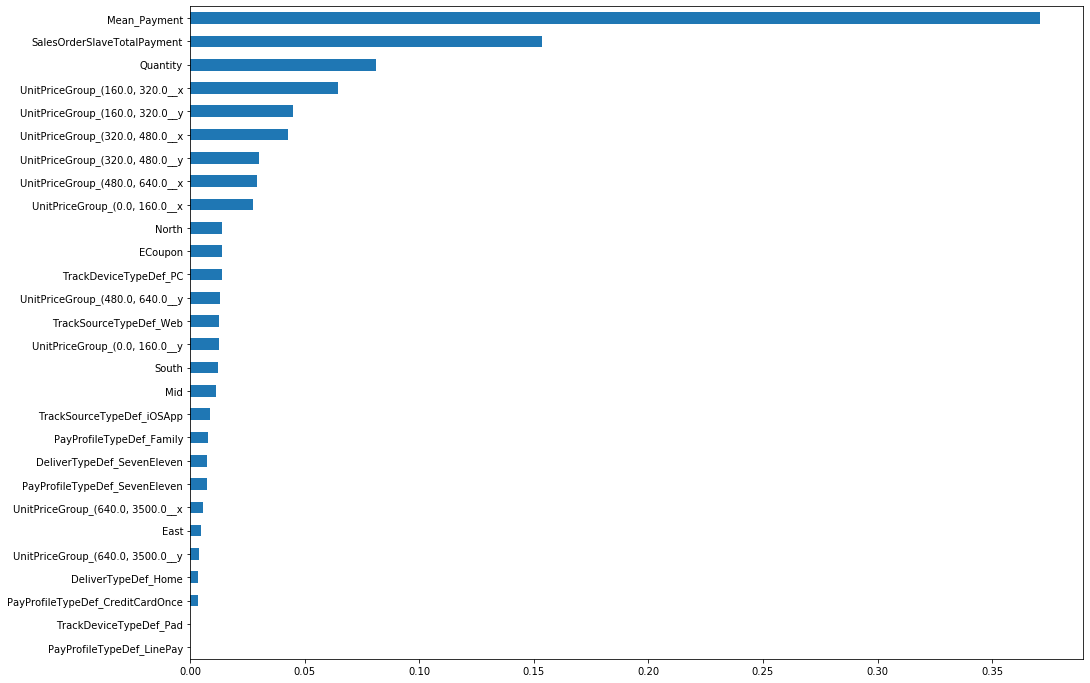

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
pd.Series(feature_importance[1], index=df_2nd.columns[2:]).sort_values().plot(kind='barh')

In [80]:
print(clre_list[0])

              precision    recall  f1-score   support

           A       0.20      0.09      0.12      4003
           B       0.46      0.30      0.37     22945
           C       0.61      0.79      0.69     28804
           D       0.65      0.49      0.56     36360
           E       0.55      0.72      0.62     22247
           F       0.55      0.78      0.64      8599

    accuracy                           0.57    122958
   macro avg       0.50      0.53      0.50    122958
weighted avg       0.56      0.57      0.56    122958



In [81]:
print(clre_list[1])

              precision    recall  f1-score   support

           A       0.43      0.26      0.33      3151
           B       0.64      0.62      0.63     16503
           C       0.47      0.62      0.54      4498
           D       0.82      0.81      0.82     24149
           E       0.42      0.51      0.46      2144
           F       0.41      0.52      0.46       383

    accuracy                           0.68     50828
   macro avg       0.53      0.56      0.54     50828
weighted avg       0.69      0.68      0.68     50828



In [82]:
print(clre_list[2])

              precision    recall  f1-score   support

           A       0.41      0.31      0.36      2435
           B       0.56      0.61      0.58     10262
           C       0.26      0.25      0.26       608
           D       0.76      0.75      0.76     13783
           E       0.20      0.15      0.17       242
           F       0.04      0.04      0.04        27

    accuracy                           0.64     27357
   macro avg       0.37      0.35      0.36     27357
weighted avg       0.64      0.64      0.64     27357



In [84]:
print(clre_list[3])

              precision    recall  f1-score   support

           A       0.40      0.36      0.38      1766
           B       0.53      0.57      0.55      6329
           C       0.17      0.14      0.15       109
           D       0.74      0.72      0.73      8354
           E       0.13      0.12      0.12        43

    accuracy                           0.62     16601
   macro avg       0.39      0.38      0.39     16601
weighted avg       0.62      0.62      0.62     16601



In [83]:
ans_sheet_list[1].head(10)

,God,Prediction,Compare
0,D,D,True
1,A,A,True
2,B,B,True
3,D,D,True
4,D,D,True
5,D,D,True
6,B,B,True
7,D,D,True
8,E,D,False
9,D,D,True
